This notebook present results for XAI, and error analysis.

Key steps:
- Correlation Analysis
- Statistical Tests
- Error Analysis

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, kruskal
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split,learning_curve
from xgboost import XGBRegressor
import shap
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_reg = pd.read_pickle('04_analyzed_data.pkl')
test_data = pd.read_pickle('04_analyzed_test_data.pkl')

In [ ]:
# Pearson (linear relationships)
for i in ['Semen Volume', 'Sperm Concentration', 'Sperm Count',
            'Total Motility', 'Progressive Motility', 'Non-progressive Motility',
            'Immotile Sperm', 'Abnormal Morphology', 'Age', 'TMS', 'USS']:
    pearson_dysfunction_dfi = pearsonr(data_reg[i], data_reg['DFI'])
    print(i,'- DFI',':', 'corr:', pearson_dysfunction_dfi[0],'pvalue:', pearson_dysfunction_dfi[1])

    # Repeat for TUNEL
    pearson_dysfunction_tunel = pearsonr(data_reg[i], data_reg['TUNEL'])
    print(i,'- TUNEL',':','corr:',pearson_dysfunction_tunel[0], 'pvalue:', pearson_dysfunction_tunel[1])
    print()

Semen Volume - DFI : corr: 0.0323785933382243 pvalue: 0.002501094430223158
Semen Volume - TUNEL : corr: 0.04952155534472666 pvalue: 3.7372560432810698e-06

Sperm Concentration - DFI : corr: 0.07510932147278095 pvalue: 2.2015479849425277e-12
Sperm Concentration - TUNEL : corr: 0.08465183352076792 pvalue: 2.450123539835186e-15

Sperm Count - DFI : corr: 0.1009947411838607 pvalue: 3.3355611131461354e-21
Sperm Count - TUNEL : corr: 0.11737702528198321 pvalue: 4.0519465654003435e-28

Total Motility - DFI : corr: -0.1966527536630702 pvalue: 1.0181540683974193e-76
Total Motility - TUNEL : corr: -0.16874493106223393 pvalue: 1.0969500588104595e-56

Progressive Motility - DFI : corr: -0.1946633036233443 pvalue: 3.4990031261391105e-75
Progressive Motility - TUNEL : corr: -0.15273169973879874 pvalue: 1.2107858908095058e-46

Non-progressive Motility - DFI : corr: -0.10726564885276965 pvalue: 9.981917229264459e-24
Non-progressive Motility - TUNEL : corr: -0.10989664155379678 pvalue: 7.84983431670717

In [ ]:
for f in ['Semen Volume Binned', 'Sperm Concentration Binned', 'Sperm Count Binned',
          'Total Motility Binned', 'Progressive Motility Binned', 'Abnormal Morphology Binned']:
          kruskal_result = kruskal(
    *[group['DFI'].values for name, group in data_reg.groupby('Semen Volume Binned', observed=True)]
)
          print(f, kruskal_result)

Semen Volume Binned KruskalResult(statistic=np.float64(25.09731100703718), pvalue=np.float64(5.450881568078426e-07))
Sperm Concentration Binned KruskalResult(statistic=np.float64(25.09731100703718), pvalue=np.float64(5.450881568078426e-07))
Sperm Count Binned KruskalResult(statistic=np.float64(25.09731100703718), pvalue=np.float64(5.450881568078426e-07))
Total Motility Binned KruskalResult(statistic=np.float64(25.09731100703718), pvalue=np.float64(5.450881568078426e-07))
Progressive Motility Binned KruskalResult(statistic=np.float64(25.09731100703718), pvalue=np.float64(5.450881568078426e-07))
Abnormal Morphology Binned KruskalResult(statistic=np.float64(25.09731100703718), pvalue=np.float64(5.450881568078426e-07))


In [ ]:
inputs = data_reg.drop(columns=['DFI','TUNEL'])
test_inputs = test_data.drop(columns=['DFI','TUNEL'])


numerical_input_features = inputs.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_input_features = inputs.select_dtypes(include=['category', 'bool']).columns.tolist()
test_numerical_input_features = test_inputs.select_dtypes(include=['float64', 'int64']).columns.tolist()
test_categorical_input_features = test_inputs.select_dtypes(include=['category', 'bool']).columns.tolist()

numerical_targets = ['DFI','TUNEL']

X_scaled = pd.DataFrame(
    RobustScaler().fit_transform(data_reg[numerical_input_features]),
    columns=numerical_input_features,
    index=data_reg.index
)
X_test_scaled = pd.DataFrame(
    RobustScaler().fit_transform(test_data[test_numerical_input_features]),
    columns=test_numerical_input_features,
    index=test_data.index
)


X_cat = pd.get_dummies(data_reg[categorical_input_features], drop_first=True)
X_test_cat = pd.get_dummies(test_data[test_categorical_input_features], drop_first=True)

#concatanate X_cat and X_scaled in data frame X
X_reg = pd.concat([X_scaled, X_cat], axis=1)
X_test_reg = pd.concat([X_test_scaled, X_test_cat], axis=1)

y_reg = data_reg[numerical_targets]
y_test_reg = test_data[numerical_targets]

In [ ]:
model_xgb = joblib.load('xgboost.pkl')

In [ ]:
y_pred_reg = model_xgb.predict(X_test_reg)

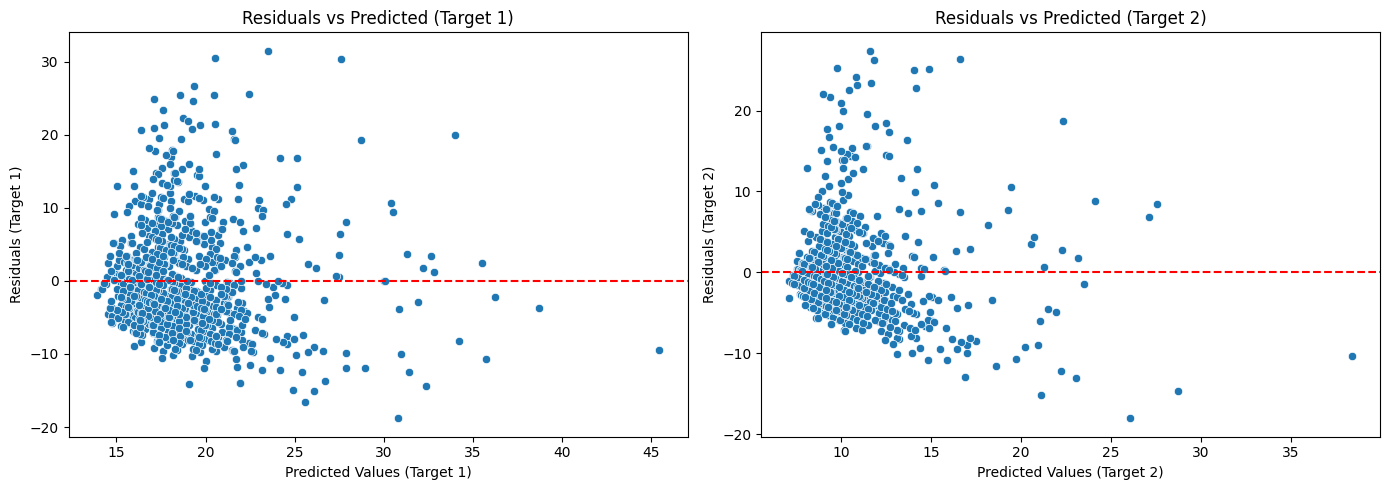

In [ ]:
# Convert to NumPy arrays first
y_test_np = y_test_reg.values
y_pred_np = y_pred_reg if isinstance(y_pred_reg, np.ndarray) else y_pred_reg.values
residuals = y_test_np - y_pred_np

# Plot residuals for both targets
plt.figure(figsize=(14, 5))

# Target 1
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_np[:, 0], y=residuals[:, 0])
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Values (Target 1)")
plt.ylabel("Residuals (Target 1)")
plt.title("Residuals vs Predicted (Target 1)")

# Target 2
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_np[:, 1], y=residuals[:, 1])
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Values (Target 2)")
plt.ylabel("Residuals (Target 2)")
plt.title("Residuals vs Predicted (Target 2)")

plt.tight_layout()
plt.show()


In [ ]:
X_reg, X_test_reg, y_reg, y_test_reg = train_test_split(X_reg, y_reg['TUNEL'], test_size=0.2, random_state=42)

# Train XGBoost model
xgb = XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
xgb.fit(X_reg, y_reg)

# Predictions
y_pred_reg = xgb.predict(X_test_reg)
y_train_pred_reg = xgb.predict(X_reg)

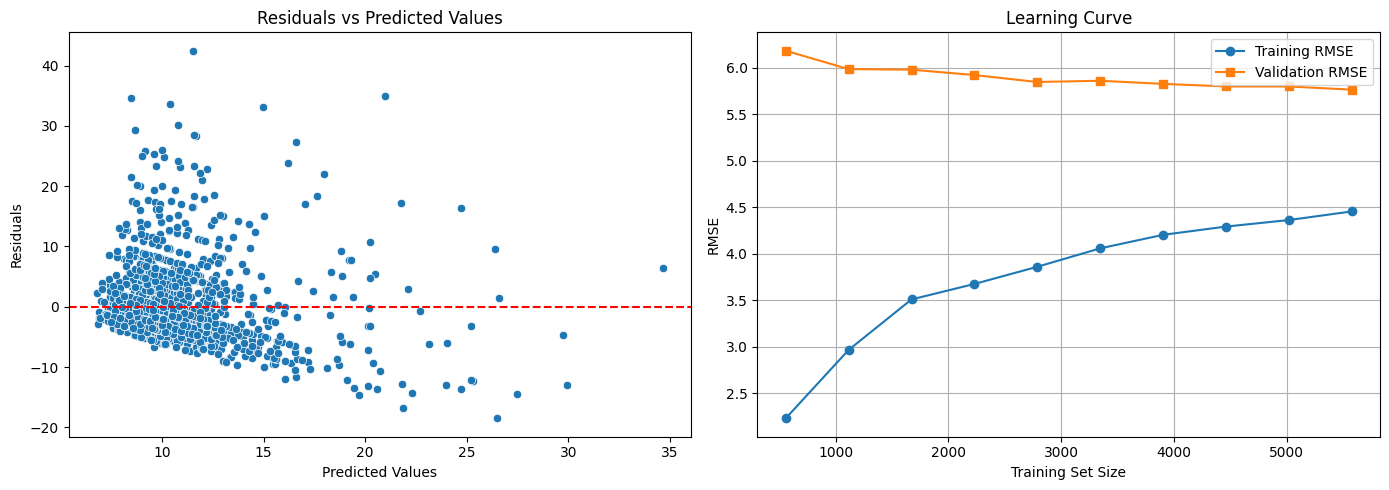

In [ ]:
# Create figure with subplots
plt.figure(figsize=(14, 5))

# First subplot: Residuals vs Predicted Values
plt.subplot(1, 2, 1)
residuals = y_test_reg - y_pred_reg
sns.scatterplot(x=y_pred_reg, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")

# Second subplot: Learning Curve
plt.subplot(1, 2, 2)
# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    xgb, X_reg, y_reg, cv=5, scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Convert negative MSE to RMSE
train_rmse = np.sqrt(-train_scores.mean(axis=1))
test_rmse = np.sqrt(-test_scores.mean(axis=1))

# Plot learning curve
plt.plot(train_sizes, train_rmse, label="Training RMSE", marker='o')
plt.plot(train_sizes, test_rmse, label="Validation RMSE", marker='s')
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.title("Learning Curve")
plt.legend()
plt.grid()

# Adjust layout and save
plt.tight_layout()
plt.savefig('model_diagnostics.png', dpi=400)
plt.show()